In [3346]:
from qick import *
%pylab inline

import time

from scipy.signal import welch
from numpy.fft import fftshift

from scipy.signal import spectrogram
from matplotlib import colors

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/Daniel/qick/.qick_venv/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['psd']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [3347]:
# Pyro to communicate with board
import Pyro4
from qick import QickConfig
Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION=4

# Static IP proxy
ns_host = "192.168.2.99"
ns_port = 8888
proxy_name = "myqick"

# QICK object
ns = Pyro4.locateNS(host=ns_host, port=ns_port)
soc = Pyro4.Proxy(ns.lookup(proxy_name))
soccfg = QickConfig(soc.get_cfg())
# print(soccfg)

In [3348]:
# to read the pickle file, use the following codes
import pickle
with open('Sequence_ch1_ch2_mw.pickle', 'rb') as handle:
    raman_cooling_sequences = pickle.load(handle)
print(raman_cooling_sequences) # will be in the form of dictionary.

{'ch1_Dig': [(100.0, 0), (47000, 1), (100.0, 0), (3000.0, 1), (1000.0, 0), (3000.0, 1), (1000.0, 0), (3000.0, 1), (1000.0, 0), (3000.0, 1), (1000.0, 0), (3000.0, 1), (1000.0, 0), (3000.0, 1), (1000.0, 0), (3000.0, 1), (1000.0, 0), (3000.0, 1), (1000.0, 0), (3000.0, 1), (1000.0, 0), (3000.0, 1), (1000.0, 0), (3000.0, 1), (1000.0, 0), (3000.0, 1), (100.0, 0)], 'ch2_Dig': [(100.0, 0), (47000, 1), (100.0, 0), (3000.0, 0), (450.0, 0), (100.0, 1), (450.0, 0), (3000.0, 0), (450.0, 0), (100.0, 1), (450.0, 0), (3000.0, 0), (450.0, 0), (100.0, 1), (450.0, 0), (3000.0, 0), (450.0, 0), (100.0, 1), (450.0, 0), (3000.0, 0), (450.0, 0), (100.0, 1), (450.0, 0), (3000.0, 0), (450.0, 0), (100.0, 1), (450.0, 0), (3000.0, 0), (450.0, 0), (100.0, 1), (450.0, 0), (3000.0, 0), (450.0, 0), (100.0, 1), (450.0, 0), (3000.0, 0), (450.0, 0), (100.0, 1), (450.0, 0), (3000.0, 0), (450.0, 0), (100.0, 1), (450.0, 0), (3000.0, 0), (450.0, 0), (100.0, 1), (450.0, 0), (3000.0, 0), (100.0, 0)], 'MW': [(100.0, 0), (47000,

In [3349]:
GEN_CH_A = 1
GEN_CH_B = 0
RO_CH_C = 1
RO_CH_D = 0
FREQ = 280 # MHz

In [3350]:
# Class containg init method to process pulse sequences for each channel
class DigitalOutput():
    sequence = []

    def __init__(self, pmod_ch, seq):
        self.pmod_ch = pmod_ch
        self.seq = seq

        # Remove pre-exisiting sequence if it already exists for channel
        for l in self.sequence[:]:
            if l[-1] == self.pmod_ch:
                self.sequence.remove(l)
        
        if self.seq != None:
            # Convert list of tuples into list of lists
            self.seq = [list(t) for t in self.seq]

            # Convert pulse widths into elapsed time and append channel to list
            time = 0
            for l in self.seq:
                l[0], time = time, time + l[0]
                l.append(pmod_ch)

            delete_indices = []
            for i in range(len(self.seq) - 1):
                if self.seq[i][1] == self.seq[i+1][1]:
                    delete_indices.append(i+1)
            for i in reversed(delete_indices):
                del self.seq[i]
            
            # End final pulse
            self.seq.append([time, 0, pmod_ch])

            # Add channel sequence to master sequence and sort in order of time
            [self.sequence.append(l) for l in self.seq]
            self.sequence.sort(key=lambda x: x[0])
        
    def configure(self):
        # print("Digital:")
        out = 0
        # trig_output = self.soccfg['tprocs'][0]['trig_output']
        for l in DigitalOutput.sequence: 
            time = int(self.us2cycles((l[0]) / 1e3))
            # print(l[0], l[0]/1e3, self.us2cycles((l[0]) / 1e3), time)
            state = l[1]
            bit_position = l[2]

            if state == 1:
                out |= (1 << bit_position)
            elif state == 0:
                out &= ~(1 << bit_position)

            rp = 0 # tproc register page
            r_out = 31 # tproc register
            # print(bin(out), time)
            # if out == 1:
            #     print(time)
            self.regwi(rp, r_out, out)
            self.seti(soccfg['tprocs'][0]['output_pins'][0][1], rp, r_out, time)

In [3351]:
def analogue_sequence(seq):
    on_durations = []
    on_times = []
    on_freqs = []

    if seq != None:
        for l in seq:
            if int(l[1]) == 1:
                on_durations.append(int(l[0])/1e3)

        time = 0
        for l in seq:
            if int(l[1]) == 1:
                on_times.append(time/1e3)
                on_freqs.append(l[2]*1e3)
            time += l[0]
        
        if len(on_durations) != len(on_times):
            raise ValueError
        
    return on_durations, on_times, on_freqs

print(raman_cooling_sequences["MW"])
on_durations, on_times, on_freqs = analogue_sequence(raman_cooling_sequences["MW"])
print(on_durations)
print(on_times)
print(on_freqs)

[(100.0, 0), (47000, 1, 0.05, 0), (100.0, 0), (3000.0, 0), (450.0, 0), (100.0, 1.0, 0.05, 0.0), (450.0, 0), (3000.0, 0), (450.0, 0), (100.0, 1.0, 0.055, 0.0), (450.0, 0), (3000.0, 0), (450.0, 0), (100.0, 1.0, 0.06, 0.0), (450.0, 0), (3000.0, 0), (450.0, 0), (100.0, 1.0, 0.065, 0.0), (450.0, 0), (3000.0, 0), (450.0, 0), (100.0, 1.0, 0.07, 0.0), (450.0, 0), (3000.0, 0), (450.0, 0), (100.0, 1.0, 0.075, 0.0), (450.0, 0), (3000.0, 0), (450.0, 0), (100.0, 1.0, 0.08, 0.0), (450.0, 0), (3000.0, 0), (450.0, 0), (100.0, 1.0, 0.085, 0.0), (450.0, 0), (3000.0, 0), (450.0, 0), (100.0, 1.0, 0.09, 0.0), (450.0, 0), (3000.0, 0), (450.0, 0), (100.0, 1.0, 0.095, 0.0), (450.0, 0), (3000.0, 0), (450.0, 0), (100.0, 1.0, 0.1, 0.0), (450.0, 0), (3000.0, 0), (100.0, 0)]
[47.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
[0.1, 50.65, 54.65, 58.65, 62.65, 66.65, 70.65, 74.65, 78.65, 82.65, 86.65, 90.65]
[50.0, 50.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 85.0, 90.0, 95.0, 100.0]


In [3352]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):

        self.declare_gen(ch=GEN_CH_A, nqz=1)

        # Enable if reading data
        self.declare_readout(ch=RO_CH_C, length=self.cfg["readout_length"], freq=0, sel="input") # TODO: is freq=0 needed?

        freq = self.freq2reg(self.cfg["pulse_freq"], gen_ch=GEN_CH_A, ro_ch=RO_CH_C)
        phase = self.deg2reg(self.cfg["res_phase"], gen_ch=GEN_CH_A)
        gain = self.cfg["pulse_gain"]
        self.default_pulse_registers(ch=GEN_CH_A, phase=phase, gain=gain)

        self.synci(200)  # give processor some time to configure pulses

        # Enable if reading data
        # self.synci(100)  # give processor some time to configure pulses
        # self.trigger(mr=True, adc_trig_offset=self.cfg["adc_trig_offset"])
        # self.synci(100)  # give the buffers a little time
        
    def body(self):
        cfg=self.cfg
        res_ch = cfg["res_ch"]
        # freq = self.freq2reg(cfg["pulse_freq"], gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])

        t_offset = 38

        self.regwi(0, 14, 9) # 10 reps
        self.label("LOOP_I")

        # Configure DAC pulses
        # print("Analogue:")
        for i in range(len(on_durations)):
            # print(self.us2cycles(on_times[i]), self.us2cycles(on_durations[i]))
            freq = self.freq2reg(on_freqs[i], gen_ch=GEN_CH_A)
            self.set_pulse_registers(ch=GEN_CH_A, freq=freq, style="const", length=self.us2cycles(on_durations[i], gen_ch=GEN_CH_A))
            self.pulse(ch=GEN_CH_A, t=self.us2cycles(on_times[i])-t_offset)

        # Configure digital pulses
        seq_0 = DigitalOutput(0, raman_cooling_sequences["ch2_Dig"])
        seq_1 = DigitalOutput(1, raman_cooling_sequences["ch1_Dig"])
        DigitalOutput.configure(self)

        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))
        self.loopnz(0, 14, "LOOP_I")

In [3353]:
# self.trigger(adcs=self.ro_chs,
#                 adc_trig_offset=self.cfg["adc_trig_offset"])

# self.trigger(adcs=self.ro_chs,
#              adc_trig_offset=self.cfg["adc_trig_offset"], t=self.us2cycles(30, gen_ch=GEN_CH_A))

In [3354]:
config={"res_ch":GEN_CH_A,
        "ro_chs":[RO_CH_C, RO_CH_D],
        "reps":1,
        "relax_delay":3.55, # [us]
        "res_phase":0, # [degrees]
        "pulse_style": "const",
        "length":500, # [Clock ticks]
        "readout_length":1000, # [Clock ticks]
        "pulse_gain":10000, # [DAC units]
        "pulse_freq": FREQ, # [MHz]
        "adc_trig_offset": 0, # [Clock ticks]
        "soft_avgs":1
       }

prog =LoopbackProgram(soccfg, config)
prog.config_all(soc)
soc.arm_mr(ch=RO_CH_D)
# n_transfers = 100000 # each transfer (aka burst) is 256 decimated samples
# soc.arm_ddr4(ch=RO_CH_C, nt=n_transfers)
prog.config_all(soc)
soc.tproc.start()
# iq_list = prog.acquire_decimated(soc, progress=False)
# print(prog)

[[100.0, 0], [47000, 1], [100.0, 0], [3000.0, 0], [450.0, 0], [100.0, 1], [450.0, 0], [3000.0, 0], [450.0, 0], [100.0, 1], [450.0, 0], [3000.0, 0], [450.0, 0], [100.0, 1], [450.0, 0], [3000.0, 0], [450.0, 0], [100.0, 1], [450.0, 0], [3000.0, 0], [450.0, 0], [100.0, 1], [450.0, 0], [3000.0, 0], [450.0, 0], [100.0, 1], [450.0, 0], [3000.0, 0], [450.0, 0], [100.0, 1], [450.0, 0], [3000.0, 0], [450.0, 0], [100.0, 1], [450.0, 0], [3000.0, 0], [450.0, 0], [100.0, 1], [450.0, 0], [3000.0, 0], [450.0, 0], [100.0, 1], [450.0, 0], [3000.0, 0], [450.0, 0], [100.0, 1], [450.0, 0], [3000.0, 0], [100.0, 0]]
[[0, 0, 0], [100.0, 1, 0], [47100.0, 0, 0], [47200.0, 0, 0], [50200.0, 0, 0], [50650.0, 1, 0], [50750.0, 0, 0], [51200.0, 0, 0], [54200.0, 0, 0], [54650.0, 1, 0], [54750.0, 0, 0], [55200.0, 0, 0], [58200.0, 0, 0], [58650.0, 1, 0], [58750.0, 0, 0], [59200.0, 0, 0], [62200.0, 0, 0], [62650.0, 1, 0], [62750.0, 0, 0], [63200.0, 0, 0], [66200.0, 0, 0], [66650.0, 1, 0], [66750.0, 0, 0], [67200.0, 0, 0]

In [3355]:
# iq_mr = soc.get_mr()
# # iq_ddr4 = soc.get_ddr4(6)
# for ii, iq in enumerate(iq_list):
#     plt.plot(iq[0][:], label="I value, ADC %d"%(config['ro_chs'][ii]))
#     # plt.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
#     # plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
# # plt.plot(iq_mr[850:950,0])
# plt.xlabel("sample number [ADC ticks]")
# plt.legend();

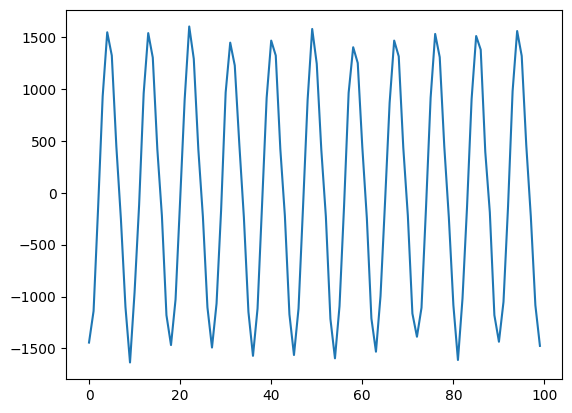

In [3356]:
iq_mr = soc.get_mr()
plt.plot(iq_mr[2000:2100,0]);

Frequency: 492.48 MHz


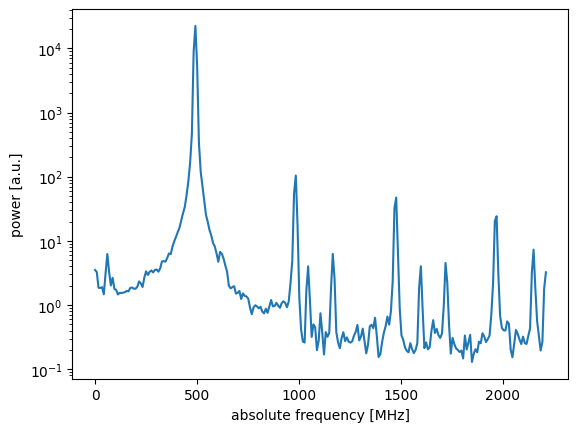

In [3357]:
complex_iq = iq_mr.dot([1,1j])
fs_adc = soccfg['readouts'][RO_CH_C]['fs']
fft_freqs, psd = welch(iq_mr[850:4000,0], fs_adc, return_onesided=True, detrend=False, nperseg=512)
plt.semilogy(fft_freqs, psd)
plt.xlabel("absolute frequency [MHz]")
plt.ylabel("power [a.u.]");
print("Frequency:", fft_freqs[argmax(psd)], "MHz")